<a href="https://colab.research.google.com/github/raitharnett/tensorflow-great-barrier-reef/blob/main/cots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [4]:
%%bash
#upgrade pip
python -m pip install --upgrade pip
# upgrade kaggle and install API token
pip install --upgrade --force-reinstall --no-deps kaggle
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# download and unzip COTS data
kaggle competitions download -c tensorflow-great-barrier-reef
unzip -d  tensorflow-great-barrier-reef tensorflow-great-barrier-reef.zip 
# download an EfficientDet-D0 base model and apply transfer learning to train a COTS detection model
wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz 
tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz 
# clone and install TF models
git clone --depth 1 https://github.com/tensorflow/models
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=58d0e9dff68235424d81c9139c47b2c488ae624e2fece2fe79e788149650abd3
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12

Archive:  tensorflow-great-barrier-reef.zip
  inflating: tensorflow-great-barrier-reef/example_sample_submission.csv  
  inflating: tensorflow-great-barrier-reef/example_test.npy  
  inflating: tensorflow-great-barrier-reef/greatbarrierreef/__init__.py  
  inflating: tensorflow-great-barrier-reef/greatbarrierreef/

100%|██████████| 14.2G/14.2G [02:33<00:00, 99.0MB/s]
--2021-12-19 10:42:06--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  224M 0s
    50K .......... .......... .......... .......... ..........  0%  165M 0s
   100K .......... .......... .......... .......... ..........  0%  142M 0s
   150K .......... .......... .......... .......... ..........  0% 92.0M 0s
   200K .......... .......... .......... .......... ..........  0%  183M 0s
   250K .......... .......... .......... .......... ..........  0%  188M 0s
   300K .......... ..

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import contextlib2
import io
import IPython
import json
import numpy as np
import os
import pathlib
import pandas as pd
import sys
import tensorflow as tf
import time
import shutil
from pathlib import Path
from enum import Enum
from google.colab import data_table
data_table.enable_dataframe_formatter()
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

# COTS testing data
COTS_DATA = '/content/tensorflow-great-barrier-reef'
sys.path.insert(0, COTS_DATA)
import greatbarrierreef

COTS_DATA_IMAGES = os.path.join(COTS_DATA,'train_images')
COTS_DATASET = '/content/dataset'
Path(COTS_DATASET).mkdir(parents=True, exist_ok=True)
COTS_DATA_TRAIN_TF_RECORDS = f'{COTS_DATASET}/train'
COTS_DATA_TEST_TF_RECORDS = f'{COTS_DATASET}/test'
COTS_MODEL_DIR='/content/cots_efficientdet_d0'
Path(COTS_MODEL_DIR).mkdir(parents=True, exist_ok=True)

class COTSClass(Enum):
  COTS = 1

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
from object_detection.utils import dataset_util
from object_detection.dataset_tools import tf_record_creation_util
import contextlib2

def create_cots_tf_example(row):
  with tf.io.gfile.GFile(row.image_path, 'rb') as fid:
    encodedJpg = fid.read()
  encodedJpgIO = io.BytesIO(encodedJpg)
  image = Image.open(encodedJpgIO)
  width = image.size[0]
  height = image.size[1]
  fileName = f'{row.image_id}'.encode('utf8')
  imageFormat = 'jpeg'.encode('utf8')
  classesText = []
  classes = []
  annotations = json.loads(row.annotations.replace("'", '"'))
  xmin = []
  ymin = []
  xmax = []
  ymax = []
  for annotation in annotations:
    xmin.append(annotation['x'] / width) 
    xmax.append((annotation['x'] + annotation['width']) / width) 
    ymin.append(annotation['y'] / height) 
    ymax.append((annotation['y'] + annotation['height']) / height) 
    classesText.append(COTSClass.COTS.name.encode('utf8'))
    classes.append(COTSClass.COTS.value)

  tfExample = tf.train.Example(features=tf.train.Features(feature={
    'image/height': dataset_util.int64_feature(height),
    'image/width': dataset_util.int64_feature(width),
    'image/filename': dataset_util.bytes_feature(fileName),
    'image/source_id': dataset_util.bytes_feature(fileName),
    'image/encoded': dataset_util.bytes_feature(encodedJpg),
    'image/format': dataset_util.bytes_feature(imageFormat),
    'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
    'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
    'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
    'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
    'image/object/class/text': dataset_util.bytes_list_feature(classesText),
    'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))

  return tfExample

def load_cots(df, basePath, numShards=10):
  with contextlib2.ExitStack() as tfRecordCloseStack:
    outputTFRecords = tf_record_creation_util.open_sharded_output_tfrecords(tfRecordCloseStack, basePath, numShards)
    for index, row in df.iterrows():
      tfExample = create_cots_tf_example(row)
      outputShardIndex = index % numShards
      outputTFRecords[outputShardIndex].write(tfExample.SerializeToString())

In [3]:
cots_df = pd.read_csv(os.path.join(COTS_DATA,'train.csv'))
cots_df['image_path'] = cots_df.apply(lambda r: os.path.join(COTS_DATA_IMAGES,f"video_{r.video_id}",f"{r.video_frame}.jpg"), axis=1)

In [4]:
cots_train_test_split = train_test_split(cots_df, train_size = 0.8)
cots_tf_record_keys = [COTS_DATA_TRAIN_TF_RECORDS, COTS_DATA_TEST_TF_RECORDS]
cots_train_test_data = {cots_tf_record_keys[i]: cots_train_test_split[i] for i in range(len(cots_train_test_split))}
for base_path, df in cots_train_test_data.items():
  load_cots(df, base_path)

In [5]:
from string import Template

TRAINING_STEPS = 5000
WARMUP_STEPS = 500
PIPELINE_CONFIG_PATH='dataset/pipeline.config'
LABEL_MAP_PATH='dataset/label_map.pbtxt'

shutil.copy('/content/drive/MyDrive/cots/label_map.txt',LABEL_MAP_PATH)

with open('/content/drive/MyDrive/cots/config_file_template.txt', mode='r') as f:
  config_file_template = f.read()
pipeline = Template(config_file_template).substitute(training_steps=TRAINING_STEPS, warmup_steps=WARMUP_STEPS)
with open(PIPELINE_CONFIG_PATH, mode='w') as f:
  f.write(pipeline)

In [6]:
%%bash -s "$COTS_MODEL_DIR" "$PIPELINE_CONFIG_PATH"
MODEL_DIR=$1
PIPELINE_CONFIG_PATH=$2
# train model
python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --model_dir=$MODEL_DIR \
    --alsologtostderr
# evaluate model
python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --model_dir=$MODEL_DIR \
    --checkpoint_dir=$MODEL_DIR \
    --eval_timeout=0 \
    --alsologtostderr
# save model
python models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path=$PIPELINE_CONFIG_PATH \
    --trained_checkpoint_dir=$MODEL_DIR \
    --output_directory=$MODEL_DIR/output \
    --alsologtostderr

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.94s).
Accumulating evaluation results...
DONE (t=4.72s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.157
 Av

2021-12-19 10:48:14.944266: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1219 10:48:14.972521 140276344166272 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I1219 10:48:14.985482 140276344166272 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1219 10:48:14.985646 140276344166272 config_util.py:552] Maybe overwriting use_bfloat16: False
I1219 10:48:15.042147 140276344166272 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b0
I1219 10:48:15.042276 140276344166272 ssd_efficientnet_bifpn_feature_extractor.py:144] 

In [7]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn_tf_odt = tf.saved_model.load(os.path.join(os.path.join(COTS_MODEL_DIR, 'output'), 'saved_model'))
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 29.19093680381775s


In [12]:
 cots_df[cots_df.index == 16]

video_id  sequence  video_frame  sequence_frame image_id  \
16         0     40258           16              16     0-16   

                                          annotations  \
16  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]   

                                           image_path  
16  /content/tensorflow-great-barrier-reef/train_i...

hullo


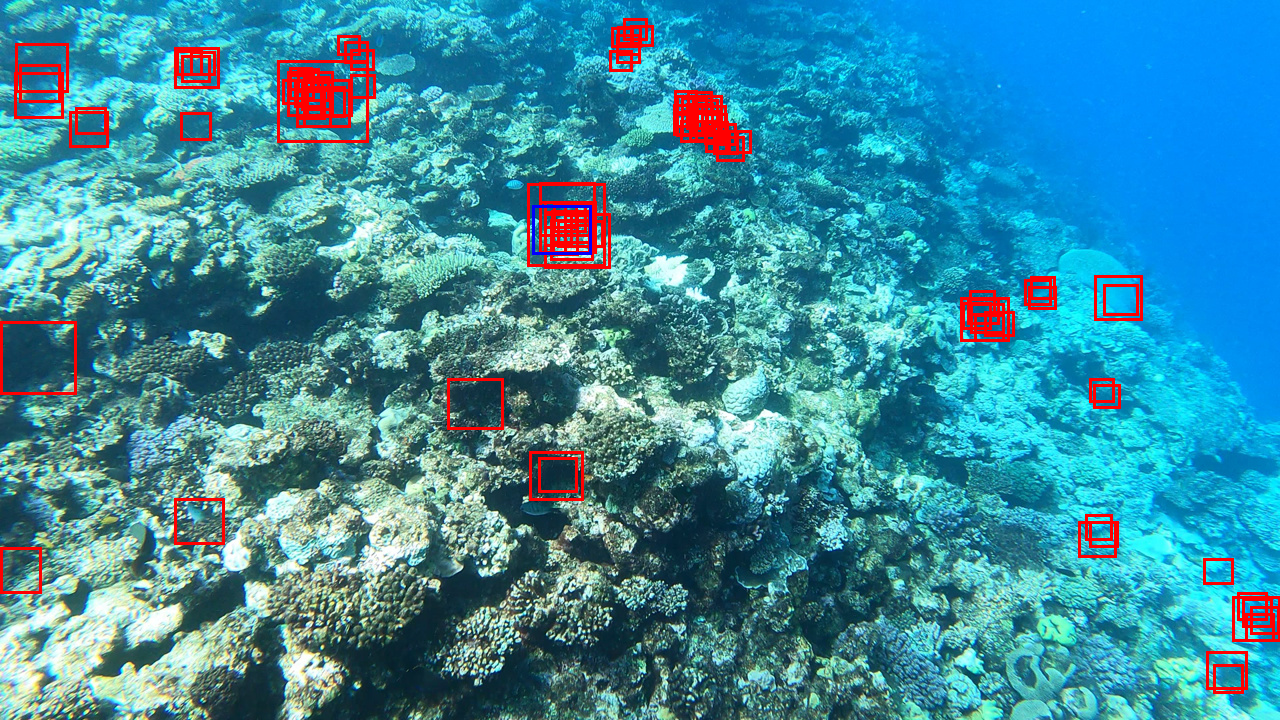

In [27]:
image_row = cots_train_test_split[0][cots_train_test_split[0].index == 24].iloc[0]
image_path = image_row.image_path
annotations =  json.loads(image_row.annotations.replace("'", '"'))
image_data = tf.io.gfile.GFile(image_path, 'rb').read()
image = Image.open(io.BytesIO(image_data))
(image_width, image_height) = image.size
xmin = []
ymin = []
xmax = []
ymax = []
for annotation in annotations:
  print("hullo")
  xmin.append(annotation['x']) 
  xmax.append((annotation['x'] + annotation['width'])) 
  ymin.append(annotation['y']) 
  ymax.append((annotation['y'] + annotation['height'])) 

image_np = np.array(image.getdata()).reshape((image_height, image_width, 3)).astype(np.uint8)
input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn_tf_odt(input_tensor)
num_detections = detections['num_detections'][0].numpy().astype(np.int32)
for index in range(num_detections):
    score = detections['detection_scores'][0][index].numpy()
    bbox = detections['detection_boxes'][0][index].numpy()
    y_min = int(bbox[0] * image_height)
    x_min = int(bbox[1] * image_width)
    y_max = int(bbox[2] * image_height)
    x_max = int(bbox[3] * image_width)
    shape = [x_min, y_min, x_max, y_max]
    ImageDraw.Draw(image).rectangle(shape, outline ="red", width=3)

for index in  range(len(xmin)):
  shape = [xmin[index], ymin[index], xmax[index], ymax[index]]
  ImageDraw.Draw(image).rectangle(shape, outline ="blue", width=3)
  
display(image)